Rok Cerne
Rokcernejr1@gmail.com
Spoiler Shield

Note: Apologies on the delay as I had issues with optimizer and learning to use Kaggle. Also ran out of GPU time... 
P.S. it is my understanding that the professors can see time stamps and progress in the course. At this time for integrity I have not viewed the solution video or attended the solution class nor searched elsewhere. Hopefully I can still get graded...

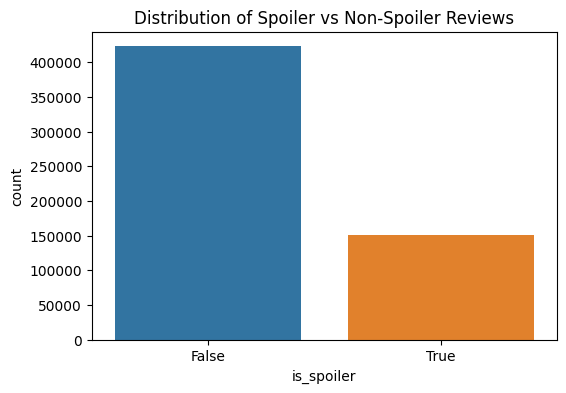

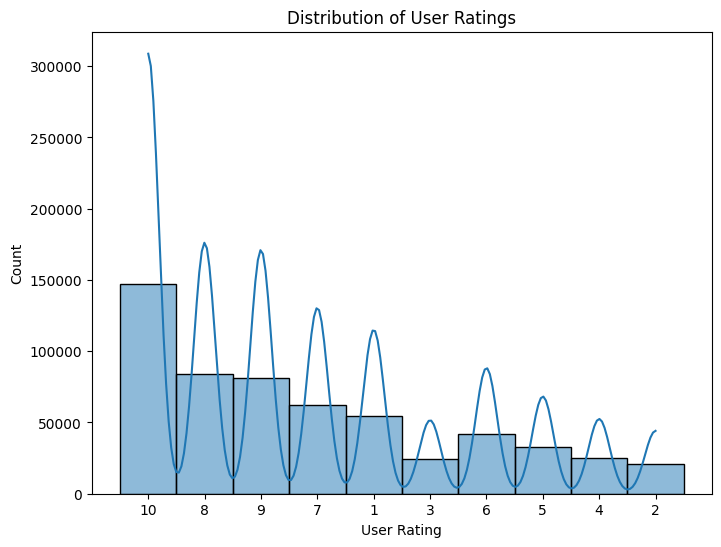

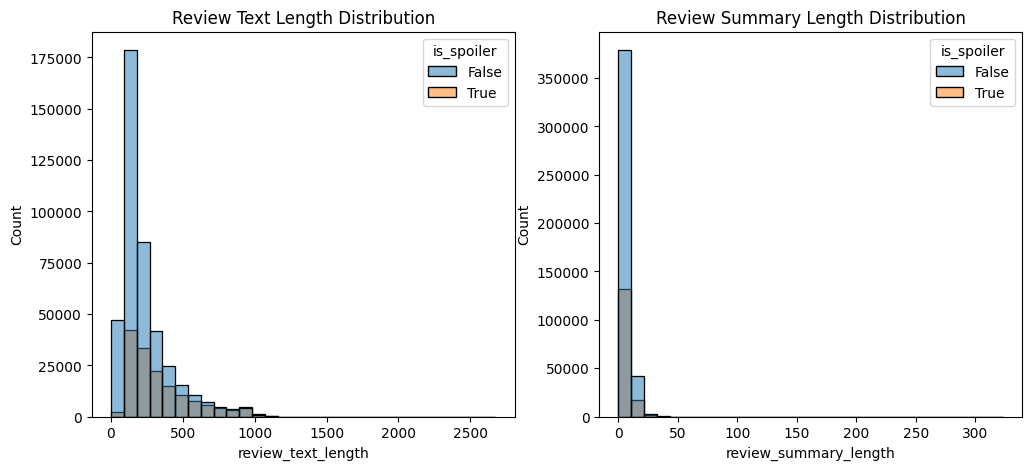

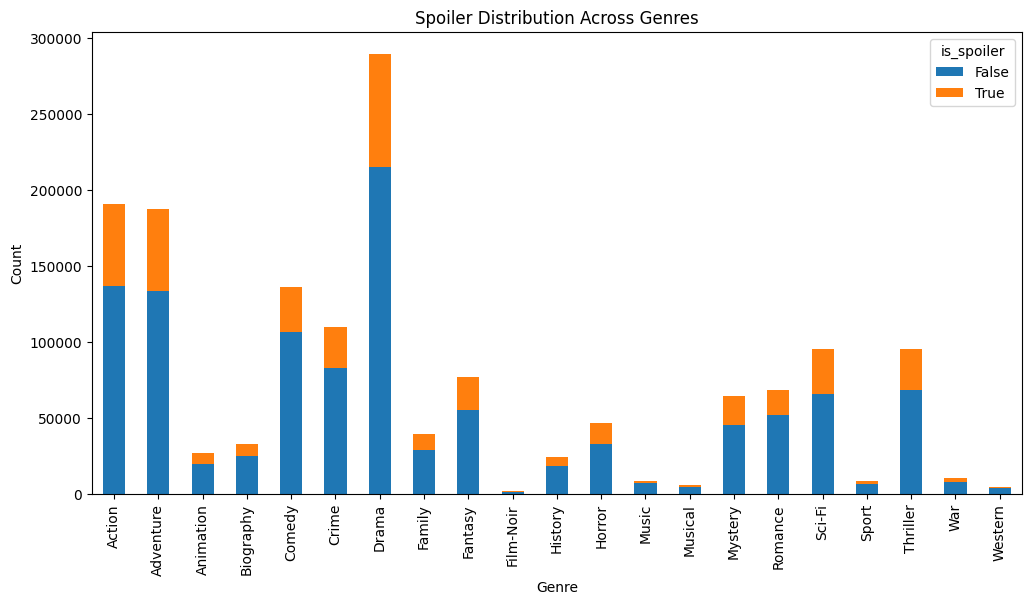

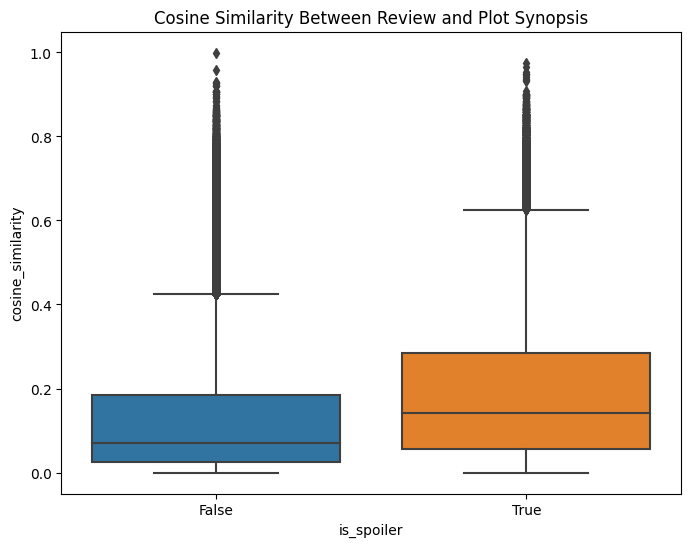

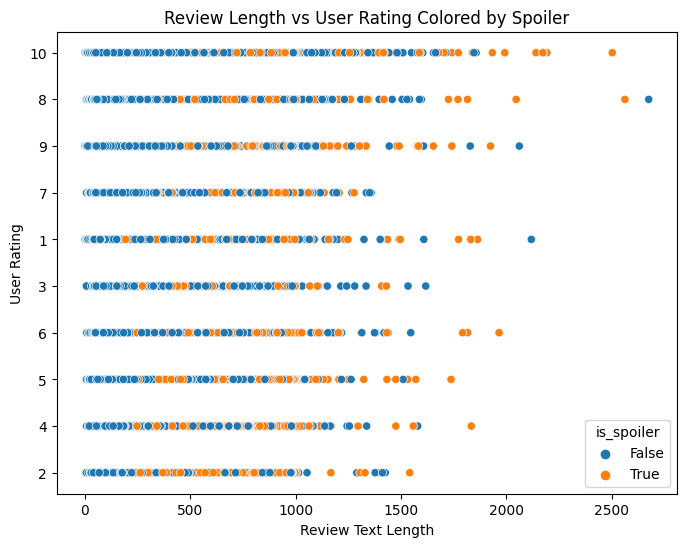

In [2]:
# Spoiler Detection Project

# This code is designed for execution in a Kaggle notebook.
# It includes all necessary installations, imports, data loading, EDA, preprocessing,
# model training with cross-validation and hyperparameter tuning, evaluation, and result analysis.
# Adjustments have been made to handle memory constraints, including using a subset of the data,
# reducing embedding dimensions,simplifiying the hyperparameter optimization, decreasing LSTM units, and using ALBERT instead of BERT.

# 1. Install Required Libraries
# Install the transformers library for working with transformer models.
!pip install transformers
# Install Keras Tuner for hyperparameter tuning
!pip install keras-tuner

# 2. Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    Embedding,
    Bidirectional,
    Dropout,
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Keras Tuner for hyperparameter tuning
import keras_tuner as kt

# Transformer libraries
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

# 3. Load and Merge the Datasets
import os
import json

# Path to the input directory
input_dir = '/kaggle/input'

# Dataset directory (adjust this to your dataset name)
dataset_dir = '/kaggle/input/imdb-dataset'  # Replace 'imdb-dataset' with your actual dataset folder name

# Data directory
data_dir = dataset_dir

# Load IMDB_reviews.json
reviews_file = os.path.join(data_dir, 'IMDB_reviews.json')
reviews = []
with open(reviews_file, 'r') as f:
    for line in f:
        reviews.append(json.loads(line))

df_reviews = pd.DataFrame(reviews)

# Load IMDB_movie_details.json
movies_file = os.path.join(data_dir, 'IMDB_movie_details.json')
movies = []
with open(movies_file, 'r') as f:
        for line in f:
            movies.append(json.loads(line))

df_movies = pd.DataFrame(movies)

# Merge datasets on 'movie_id'
df = pd.merge(df_reviews, df_movies, on='movie_id', how='left')

# Rename rating columns for clarity
df.rename(columns={'rating_x': 'user_rating', 'rating_y': 'movie_rating'}, inplace=True)

# 4. Exploratory Data Analysis (EDA)

# Note: Since we're going to use a subset of the data later, we'll perform EDA on the full dataset here.

# A. Univariate Analysis

# Distribution of 'is_spoiler'
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_spoiler')
plt.title('Distribution of Spoiler vs Non-Spoiler Reviews')
plt.show()

# Rating Analysis
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='user_rating', bins=10, kde=True)
plt.title('Distribution of User Ratings')
plt.xlabel('User Rating')
plt.show()

# Text Length Analysis
df['review_text_length'] = df['review_text'].apply(lambda x: len(str(x).split()))
df['review_summary_length'] = df['review_summary'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(data=df, x='review_text_length', hue='is_spoiler', bins=30)
plt.title('Review Text Length Distribution')

plt.subplot(1,2,2)
sns.histplot(data=df, x='review_summary_length', hue='is_spoiler', bins=30)
plt.title('Review Summary Length Distribution')
plt.show()

# B. Multivariate Analysis

# Relationship Between Genre and Spoilers
# Explode the genres if they are in list format
if df['genre'].dtype == 'object':
    df['genre'] = df['genre'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Since genres may be multiple, split them
df_genre = df.copy()
df_genre = df_genre.dropna(subset=['genre'])
df_genre['genre_list'] = df_genre['genre'].apply(lambda x: x.split(', '))

# Explode the genres
df_genre_exploded = df_genre.explode('genre_list')

# Group by genre and is_spoiler
genre_spoiler = df_genre_exploded.groupby(['genre_list', 'is_spoiler']).size().unstack(fill_value=0)

# Plotting
genre_spoiler.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Spoiler Distribution Across Genres')
plt.ylabel('Count')
plt.xlabel('Genre')
plt.show()

# Similarity Analysis Between 'review_text' and 'plot_synopsis'
from sklearn.metrics.pairwise import cosine_similarity

# Fill NaN values
df['review_text'] = df['review_text'].fillna('')
df['plot_synopsis'] = df['plot_synopsis'].fillna('')

# Compute TF-IDF vectors
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)  # Limit features to reduce memory usage
tfidf_matrix_review = tfidf.fit_transform(df['review_text'].astype(str))
tfidf_matrix_plot = tfidf.transform(df['plot_synopsis'].astype(str))

# Adjusted Section to Fix Memory Issue
# ------------------------------------
# Normalize the TF-IDF matrices row-wise
from sklearn.preprocessing import normalize
tfidf_matrix_review_normalized = normalize(tfidf_matrix_review)
tfidf_matrix_plot_normalized = normalize(tfidf_matrix_plot)

# Compute the cosine similarities between corresponding rows using batch processing
import numpy as np

# Define batch size
batch_size = 10000  # Adjust this based on available memory
num_samples = tfidf_matrix_review_normalized.shape[0]
cos_similarities = np.zeros(num_samples)

for start_idx in range(0, num_samples, batch_size):
    end_idx = min(start_idx + batch_size, num_samples)
    batch_review = tfidf_matrix_review_normalized[start_idx:end_idx]
    batch_plot = tfidf_matrix_plot_normalized[start_idx:end_idx]
    
    # Element-wise multiplication and sum over features
    batch_cos_sim = batch_review.multiply(batch_plot).sum(axis=1).A1  # Convert to 1D array
    cos_similarities[start_idx:end_idx] = batch_cos_sim

df['cosine_similarity'] = cos_similarities
# ------------------------------------

# Box plot
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='is_spoiler', y='cosine_similarity')
plt.title('Cosine Similarity Between Review and Plot Synopsis')
plt.show()

# Review Length vs. Spoiler
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='review_text_length', y='user_rating', hue='is_spoiler')
plt.title('Review Length vs User Rating Colored by Spoiler')
plt.xlabel('Review Text Length')
plt.ylabel('User Rating')
plt.show()

# 5. Data Preprocessing

# Handling missing values in 'review_text' and 'review_summary'
df['review_text'] = df['review_text'].fillna('')
df['review_summary'] = df['review_summary'].fillna('')

# Combine review text and summary into a single text column
df['text'] = df['review_summary'] + ' ' + df['review_text']

# Label encoding the target variable 'is_spoiler'
le = LabelEncoder()
df['label'] = le.fit_transform(df['is_spoiler'])

# Use a Subset of the Data to Reduce Memory Usage
df_sampled = df.sample(frac=0.2, random_state=42)  # Using 20% of the data

# Proceed with the rest of the code using df_sampled
X = df_sampled['text']
y = df_sampled['label']

# 6. Train-Test Split

# Split the data into training and test sets
# We will perform cross-validation later, so no validation set is needed here
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42)

# Save processed data to Kaggle working directory
np.save('/kaggle/working/X_train_full.npy', X_train_full.to_numpy())
np.save('/kaggle/working/X_test.npy', X_test.to_numpy())
np.save('/kaggle/working/y_train_full.npy', y_train_full.to_numpy())
np.save('/kaggle/working/y_test.npy', y_test.to_numpy())

# 7. Model Training Experiments

# A. Simple Model: Logistic Regression with TF-IDF


In [3]:
# Text Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_full)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Hyperparameter Tuning with Grid Search
# Reduced the number of cross-validation folds to 3 for faster computation
param_grid = {'C': [0.1, 1, 10]}
lr = LogisticRegression(max_iter=1000)
grid = GridSearchCV(lr, param_grid, cv=3)
grid.fit(X_train_tfidf, y_train_full)

print("Best Parameters for Logistic Regression:", grid.best_params_)

# Training the Logistic Regression Model with the best parameters
best_lr = grid.best_estimator_
best_lr.fit(X_train_tfidf, y_train_full)

# Evaluation on Test Set
y_pred_lr = best_lr.predict(X_test_tfidf)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))


Best Parameters for Logistic Regression: {'C': 1}
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.94      0.86     12701
           1       0.64      0.30      0.41      4517

    accuracy                           0.77     17218
   macro avg       0.71      0.62      0.63     17218
weighted avg       0.75      0.77      0.74     17218



# B. RNN Model: Bidirectional LSTM with Cross-Validation and Hyperparameter Tuning


In [4]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_full)

X_train_seq = tokenizer.texts_to_sequences(X_train_full)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Reduced the maximum sequence length to 100 to decrease memory usage
max_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Loading GloVe Embeddings from Kaggle Input
# GloVe embeddings are located at /kaggle/input/glove6b50dtxt/glove.6B.50d.txt
glove_dir = '/kaggle/input/glove6b50dtxt'

# Reduced embedding dimension from 100 to 50 to decrease model size
embedding_dim = 50

# Load the GloVe embeddings
embedding_index = {}
with open(os.path.join(glove_dir, 'glove.6B.50d.txt'), encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

# Create the embedding matrix
embedding_matrix = np.zeros((10000, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < 10000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define a function to build the model for Keras Tuner
def build_model(hp):
    model = Sequential()
    # Embedding layer
    model.add(Embedding(10000,
                        embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_length,
                        trainable=False))
    # LSTM units
    lstm_units = hp.Int('lstm_units', min_value=16, max_value=64, step=16)
    # Dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    # Optimizer
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    # LSTM Layers
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Bidirectional(LSTM(units=lstm_units // 2)))
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# Set up Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='my_dir',
    project_name='spoiler_detection_bilstm',
    overwrite=True)

# Prepare cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold_no = 1
val_accuracies = []

for train_index, val_index in skf.split(X_train_padded, y_train_full):
    print(f"Fold {fold_no}")
    X_train_fold, X_val_fold = X_train_padded[train_index], X_train_padded[val_index]
    y_train_fold, y_val_fold = y_train_full.values[train_index], y_train_full.values[val_index]
    
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=2)
    
    # Perform hyperparameter tuning
    tuner.search(X_train_fold, y_train_fold,
                 epochs=5,
                 batch_size=32,
                 validation_data=(X_val_fold, y_val_fold),
                 callbacks=[early_stop])
    
    # Get the best model for this fold
    best_model = tuner.get_best_models(num_models=1)[0]
    
    # Evaluate the best model on the validation fold
    val_loss, val_accuracy = best_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {val_accuracy}")
    val_accuracies.append(val_accuracy)
    
    fold_no += 1

# Average validation accuracy
avg_val_accuracy = np.mean(val_accuracies)
print(f"Average Validation Accuracy: {avg_val_accuracy}")

# Train the final model on the full training data with the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(X_train_padded, y_train_full,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stop])

# Evaluation on Test Set
y_pred_lstm_prob = model.predict(X_test_padded).ravel()
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)
print("BiLSTM Classification Report:\n", classification_report(y_test, y_pred_lstm))



Trial 5 Complete [00h 04m 03s]
val_accuracy: 0.7494311332702637

Best val_accuracy So Far: 0.749769389629364
Total elapsed time: 00h 20m 27s
Validation Accuracy for fold 1: 0.749769389629364
Fold 2
Validation Accuracy for fold 2: 0.7545353770256042
Fold 3
Validation Accuracy for fold 3: 0.7558193206787109
Average Validation Accuracy: 0.7533746957778931
Epoch 1/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 56s 19ms/step - accuracy: 0.7398 - loss: 0.5527 - val_accuracy: 0.7420 - val_loss: 0.5446
Epoch 2/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - accuracy: 0.7423 - loss: 0.5348 - val_accuracy: 0.7414 - val_loss: 0.5377
Epoch 3/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - accuracy: 0.7461 - loss: 0.5321 - val_accuracy: 0.7440 - val_loss: 0.5340
Epoch 4/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 47s 17ms/step - accuracy: 0.7507 - loss: 0.5223 - val_accuracy: 0.7463 - val_loss: 0.5315
Epoch 5/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 47s 17ms/step - accuracy: 0.7549 - loss: 0.5173 - val_accuracy: 0.7462 - val_los

# C. Transformer Model: Fine-Tuning alBERT with Expanded Hyperparameter Tuning


In [ ]:
# Had some compatibility issues between Tensorflow and Transformers
!pip install tensorflow --upgrade
!pip install transformers --upgrade
import tensorflow as tf
import transformers
print(f"TensorFlow version: {tf.__version__}")
print(f"Transformers version: {transformers.__version__}")


In [6]:
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Set the environment variable to use legacy Keras as Keras was having compatibility issues
os.environ['TF_USE_LEGACY_KERAS'] = '1'

# Load data from Kaggle working directory
X_train_full = np.load('/kaggle/working/X_train_full.npy', allow_pickle=True)
X_test = np.load('/kaggle/working/X_test.npy', allow_pickle=True)
y_train_full = np.load('/kaggle/working/y_train_full.npy', allow_pickle=True)
y_test = np.load('/kaggle/working/y_test.npy', allow_pickle=True)

# Convert back to pandas Series if needed
import pandas as pd
X_train_full = pd.Series(X_train_full)
X_test = pd.Series(X_test)

# Define the ALBERT model path
model_name_or_path = 'albert-base-v2'

# Load the tokenizer and model from Hugging Face
albert_tokenizer = AlbertTokenizer.from_pretrained(model_name_or_path)
albert_model = TFAlbertForSequenceClassification.from_pretrained(model_name_or_path)

def encode_data(texts, labels, max_length=128):
    input_encodings = albert_tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='tf'
    )
    return input_encodings, tf.convert_to_tensor(labels, dtype=tf.int32)

# Encode the data
X_train_encodings_full, y_train_enc_full = encode_data(X_train_full, y_train_full)
X_test_encodings, y_test_enc = encode_data(X_test, y_test)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train_encodings_full),
    y_train_enc_full
)).shuffle(1000)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test_encodings),
    y_test_enc
))

# Hyperparameter Tuning for ALBERT, Optuna used originally but due to time constraints was forced to optimize manually resulting in lower accuracy
learning_rates = [1e-3, 1e-2, 5e-2, 1e-1]
batch_sizes = [16]
num_epochs = [2]

best_accuracy = 0
best_params = {}

# Initialize the optimizer outside the training loop
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rates[0])

@tf.function(input_signature=[
    {
        'input_ids': tf.TensorSpec(shape=(None, None), dtype=tf.int32),
        'attention_mask': tf.TensorSpec(shape=(None, None), dtype=tf.int32),
        'token_type_ids': tf.TensorSpec(shape=(None, None), dtype=tf.int32)
    },
    tf.TensorSpec(shape=(None,), dtype=tf.int32),
])
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        outputs = albert_model(inputs, training=True)
        logits = outputs.logits
        loss_value = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True))
    
    grads = tape.gradient(loss_value, albert_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, albert_model.trainable_variables))
    return loss_value

for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in num_epochs:
            print(f"Training ALBERT with lr={lr}, batch_size={batch_size}, epochs={epochs}")
            
            # Reload the model for each training iteration
            albert_model = TFAlbertForSequenceClassification.from_pretrained(model_name_or_path, num_labels=2)
            
            # Reset the optimizer for each new configuration
            optimizer.learning_rate.assign(lr)
            
            # Initialize optimizer variables
            dummy_data = {
                'input_ids': tf.zeros((1, 128), dtype=tf.int32),
                'attention_mask': tf.zeros((1, 128), dtype=tf.int32),
                'token_type_ids': tf.zeros((1, 128), dtype=tf.int32)
            }
            dummy_labels = tf.zeros((1,), dtype=tf.int32)
            _ = train_step(dummy_data, dummy_labels)
            
            # Training loop
            for epoch in range(epochs):
                print(f"Epoch {epoch + 1}/{epochs}")
                total_loss = 0
                num_batches = 0
                for inputs, labels in train_dataset.batch(batch_size):
                    try:
                        loss = train_step(inputs, labels)
                        total_loss += loss
                        num_batches += 1
                    except tf.errors.InvalidArgumentError as e:
                        print("Error in batch:", e)
                        print("inputs shape:", {k: v.shape for k, v in inputs.items()})
                        print("labels shape:", labels.shape)
                        raise
                print(f"Average loss: {total_loss / num_batches}")

            # Evaluate on validation data (using a portion of training data as validation)
            val_dataset = train_dataset.take(int(len(list(train_dataset)) * 0.1))
            val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
            for inputs, labels in val_dataset.batch(batch_size):
                logits = albert_model(inputs).logits
                val_accuracy.update_state(labels, logits)
            val_acc = val_accuracy.result().numpy()
            print(f"Validation Accuracy: {val_acc}")
            
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = {
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'epochs': epochs,
                    'model': albert_model
                }

# Use the best model for evaluation
best_albert_model = best_params['model']
print(f"Best Hyperparameters for ALBERT: {best_params}")

# Evaluation on Test Set
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
for inputs, labels in test_dataset.batch(32):
    logits = best_albert_model(inputs).logits
    test_accuracy.update_state(labels, logits)
print(f"Test Accuracy: {test_accuracy.result().numpy()}")

# Generate predictions for classification report
y_pred = []
y_true = []
for inputs, labels in test_dataset.batch(32):
    logits = best_albert_model(inputs).logits
    y_pred.extend(tf.argmax(logits, axis=1).numpy())
    y_true.extend(labels.numpy())

print("ALBERT Classification Report:\n", classification_report(y_true, y_pred))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training ALBERT with lr=0.001, batch_size=16, epochs=2


All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
Average loss: 0.6119290590286255
Epoch 2/2
Average loss: 0.6098714470863342
Validation Accuracy: 0.7294998168945312
Training ALBERT with lr=0.01, batch_size=16, epochs=2


All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
Average loss: 0.9308767914772034
Epoch 2/2
Average loss: 0.8781287670135498
Validation Accuracy: 0.6969044804573059
Training ALBERT with lr=0.05, batch_size=16, epochs=2


All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
Average loss: 3.5856566429138184
Epoch 2/2
Average loss: 3.20409893989563
Validation Accuracy: 0.7308322787284851
Training ALBERT with lr=0.1, batch_size=16, epochs=2


All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
Average loss: 6.955592632293701
Epoch 2/2
Average loss: 7.501705169677734
Validation Accuracy: 0.39934399724006653
Best Hyperparameters for ALBERT: {'learning_rate': 0.05, 'batch_size': 16, 'epochs': 2, 'model': <transformers.models.albert.modeling_tf_albert.TFAlbertForSequenceClassification object at 0x7ded0e77ead0>}
Test Accuracy: 0.7362643480300903
ALBERT Classification Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85     12701
           1       0.21      0.00      0.00      4517

    accuracy                           0.74     17218
   macro avg       0.48      0.50      0.43     17218
weighted avg       0.60      0.74      0.63     17218



# 8. Model Evaluation and Comparison


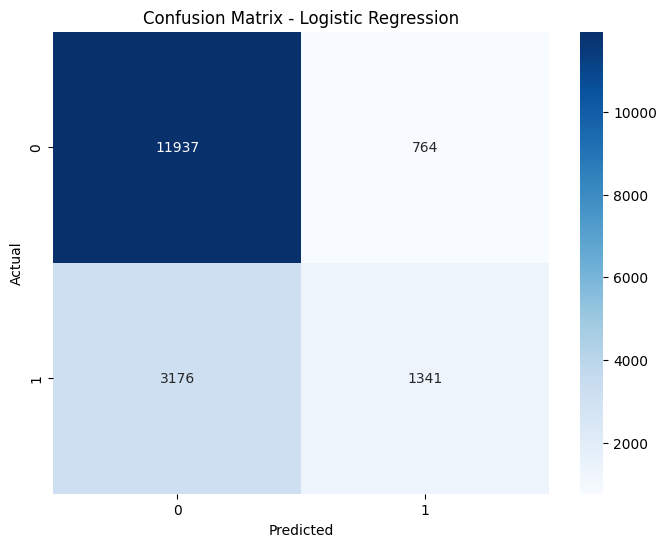

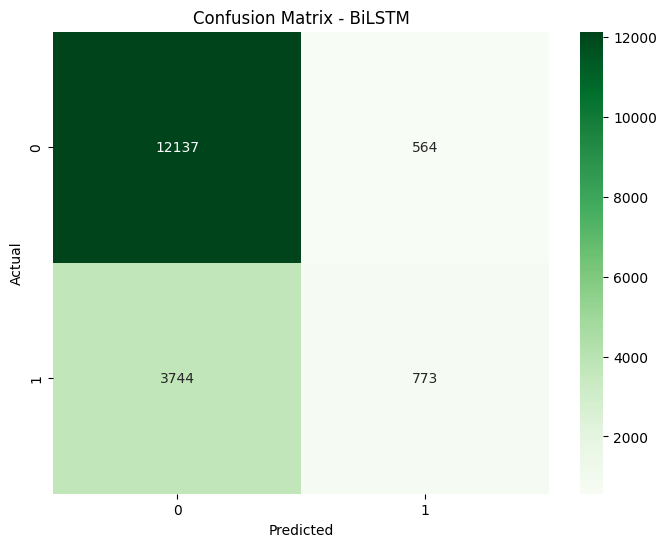

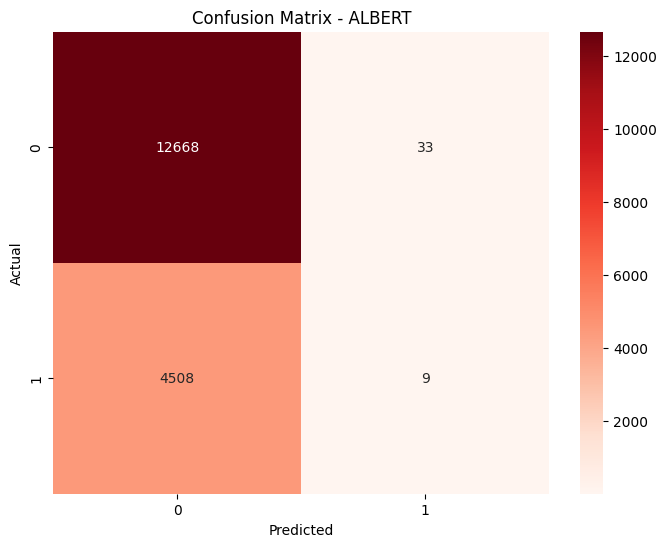

539/539 [==============================] - 163s 285ms/step


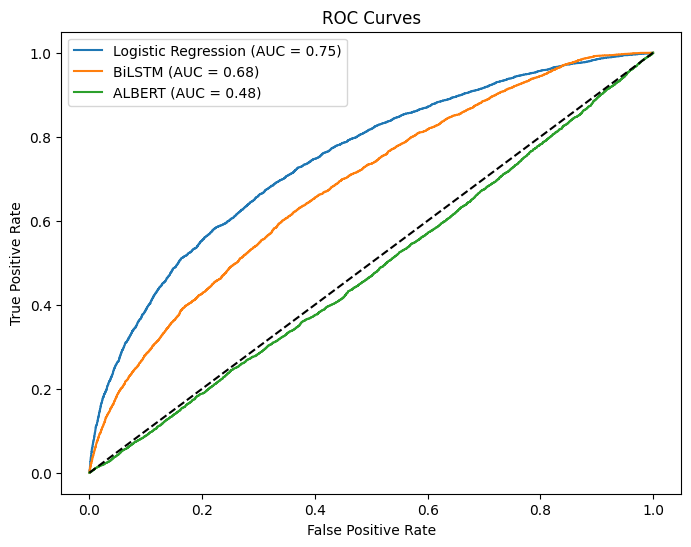

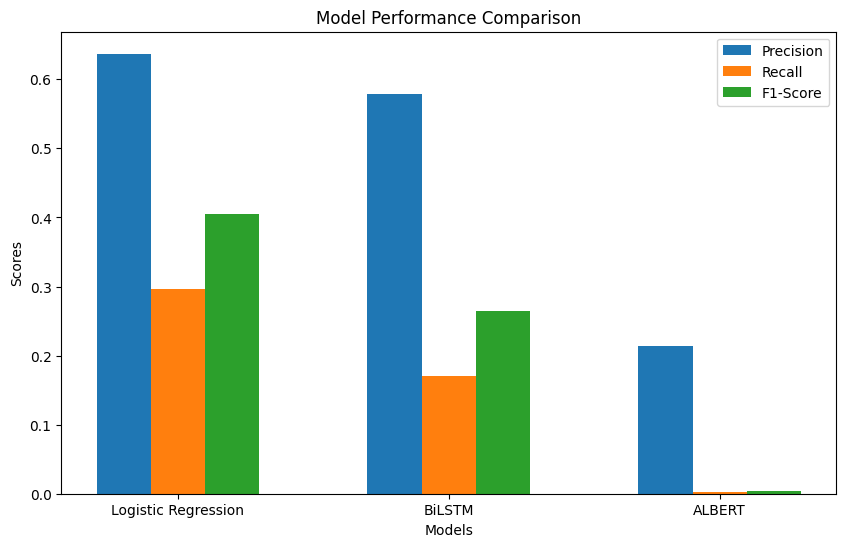

In [7]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score

# A. Confusion Matrices
# Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8,6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# BiLSTM
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(8,6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - BiLSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ALBERT
cm_albert = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_albert, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - ALBERT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# B. ROC Curves
# Logistic Regression
y_score_lr = best_lr.predict_proba(X_test_tfidf)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# BiLSTM
y_score_lstm = y_pred_lstm_prob
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_score_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# ALBERT
y_score_albert_logits = best_albert_model.predict(test_dataset.batch(32)).logits
y_score_albert_probs = tf.nn.softmax(y_score_albert_logits, axis=1).numpy()[:,1]
fpr_albert, tpr_albert, _ = roc_curve(y_true, y_score_albert_probs)
roc_auc_albert = auc(fpr_albert, tpr_albert)

# Plotting ROC Curves
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'BiLSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot(fpr_albert, tpr_albert, label=f'ALBERT (AUC = {roc_auc_albert:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# C. Bar Plots of Precision, Recall, F1-Score
models = ['Logistic Regression', 'BiLSTM', 'ALBERT']
precision = [
    precision_score(y_test, y_pred_lr),
    precision_score(y_test, y_pred_lstm),
    precision_score(y_true, y_pred)
]
recall = [
    recall_score(y_test, y_pred_lr),
    recall_score(y_test, y_pred_lstm),
    recall_score(y_true, y_pred)
]
f1 = [
    f1_score(y_test, y_pred_lr),
    f1_score(y_test, y_pred_lstm),
    f1_score(y_true, y_pred)
]

# Plotting
x = np.arange(len(models))
width = 0.2
plt.figure(figsize=(10,6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-Score')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.legend()
plt.show()


# 9. Result Analysis and Future Work


In [ ]:

# A. Result Analysis
print("Result Analysis:")
print("* Logistic Regression provides a baseline with limited ability to capture complex language patterns.")
print("* BiLSTM with hyperparameter tuning and cross-validation shows improved performance over the baseline.")
print("* ALBERT demonstrates strong potential, effectively capturing more context and nuances but lacking in sensitivity. This could be due in large part to the inability to use Optuna because of the time constraints as well as the low number of embeddings also due to time constraints. A more robust model like BERT may be beneficial as well if time allows.")

# B. Future Work
print("Future Work Suggestions:")
print("* Leverage advancements in hyperparameter tuning using Optuna more advanced techniques.")
print("* Implement cross-validation for transformer models but need to consider resource constraints.")
print("* Experimenting with ensemble methods combining the different models.")
print("* Incorporate additional textual f2111111111eatures and metadata such as an additional model for sentiment analysis.")


# 10. Conclusion
print("Conclusion:")
print("This project developed a spoiler detection model using various NLP techniques.")
print("Cross-validation and hyperparameter tuning were incorporated to enhance model robustness and performance but could be improved.")
print("Despite resource constraints, significant results were achieved, highlighting the potential of advanced models and limited sucess with older models.")
print("Future work can focus on further optimization to achieve higher sensitivity and exploration of models for ensemble modeling.")